In [1]:
import tensorflow as tf
import numpy as np
import sys
from datetime import datetime
from functools import partial
from utils import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

MODEL_PATH = "models/autoencoder/"

In [2]:
height = 28
width = 28
channels = 1
n_inputs = height * width

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, n_inputs) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, n_inputs) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
nb_samples_taken = 60000
X_train = X_train[:nb_samples_taken]
y_train = y_train[:nb_samples_taken]

In [5]:
tf.reset_default_graph()

n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [6]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sys.stdout.flush()
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        save_path = saver.save(sess, MODEL_PATH + "autoencoder.ckpt")
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18352.875 	Reconstruction loss: 14592.332 	Latent loss: 3760.5435
1 Train total loss: 17377.71 	Reconstruction loss: 13695.664 	Latent loss: 3682.0479
2 Train total loss: 16646.586 	Reconstruction loss: 12933.568 	Latent loss: 3713.0176
3 Train total loss: 16233.681 	Reconstruction loss: 12413.717 	Latent loss: 3819.9639
4 Train total loss: 16194.602 	Reconstruction loss: 12527.802 	Latent loss: 3666.8003
5 Train total loss: 16202.99 	Reconstruction loss: 12417.27 	Latent loss: 3785.7212
6 Train total loss: 16232.941 	Reconstruction loss: 12514.857 	Latent loss: 3718.084
7 Train total loss: 15576.213 	Reconstruction loss: 11915.837 	Latent loss: 3660.376
8 Train total loss: 16124.787 	Reconstruction loss: 12323.787 	Latent loss: 3800.9998
9 Train total loss: 15360.777 	Reconstruction loss: 11713.287 	Latent loss: 3647.49
10 Train total loss: 15817.904 	Reconstruction loss: 12136.766 	Latent loss: 3681.139
11 Train total loss: 15410.1875 	Reconstruction loss: 11662.7

### Digit creation with autoencoder

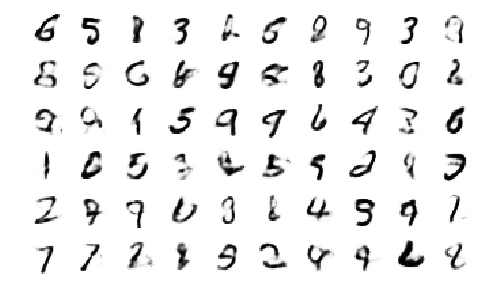

In [7]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

### Hand written digits

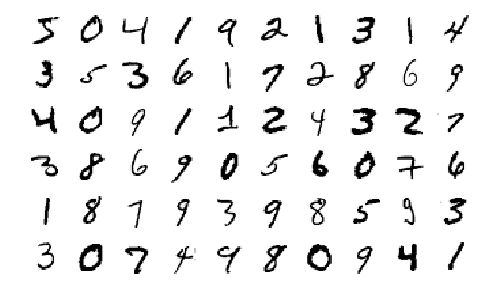

In [8]:
n_digits = 60

plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(X_train[iteration])

Our model creates digit close to real hand written digits

### Restore model used for unsupervised pre-training

In [ ]:
with tf.Session() as sess:
    # Restore variables from disk.
    model_pretrained = saver.restore(sess, MODEL_PATH + "autoencoder.ckpt")
    # displaying the model's layers
    for i, layer in enumerate(model_pretrained.layers):
        print(i, layer.name)

### adding layers at the end of the pretrained model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
x = model_pretrained.output
# Adding a fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dense(200, activation='relu')(x)
# Adding a fully connected layer for the 10 classes 0 to 9
predictions = Dense(10, activation='softmax')(x)

### freezing model

In [ ]:
model = Model(inputs=model_pretrained.input, outputs=predictions)

# freeze all layers of the pre-trained model
# we will only train the Dense layers added in "model"
for layer in model_pretrained.layers:
    layer.trainable = False

# compile the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])